# Prediction of the probability of death of a patient that is entering an ICU (Intensive Care Unit)
## Using KNN and SVM

**Andrés Felipe Virgüez Clavijo**

This notebook shows the process of fitting KNN and SVM models into a dataset from MIMIC project (https://mimic.physionet.org/). MIMIC-III (Medical Information Mart for Intensive Care III) is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012.

Each row of *mimic_train.csv* correponds to one ICU stay (*hadm_id*+*icustay_id*) of one patient (*subject_id*). Column HOSPITAL_EXPIRE_FLAG is the indicator of death (=1) as a result of the current hospital stay; this is the outcome to predict in our modelling exercise.
The remaining columns correspond to vitals of each patient (when entering the ICU), plus some general characteristics (age, gender, etc.), and their explanation can be found at *mimic_patient_metadata.csv*.  

The data used in this notebook results from a pre-processing process that is detailed in the notebook Data_preparation.ipynb (https://github.com/andresvBSE/BSE-CML2-P12/blob/main/Data_preparation.ipynb)

**Import the basic libraries**

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import sklearn

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

In [4]:
import sys
sys.path.append('src/features')

from customplots import *
from reweight_proba import *

**Import the data**

In [5]:
train = pd.read_csv('data/processed/train.csv') 
train.set_index('icustay_id', inplace=True)

print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20885 entries, 228357 to 258400
Columns: 811 entries, HeartRate_Min to ICD9_0_L1_1_2_3
dtypes: float64(811)
memory usage: 129.4 MB
None


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_O_10_L1_ICD9_CODE_O_6_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_7_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_8_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_9_L1,GENDER_ICD9DIAG,AGE_ICD9DIAG,GENDER_AGE_ICD9DIAG,ICD9_diagnosis_1_2,ICD9_0_L1_1_2,ICD9_0_L1_1_2_3
icustay_id,,,,,,,,,,,,,,,,,,,,,
228357,1.33218,1.948876,2.403148,-1.006425,-1.021078,-0.772756,-0.202861,0.088173,-0.127848,0.189415,...,1.509058,-0.398645,0.929949,0.367890,-0.720769,0.232231,0.355083,-0.187505,-0.222547,0.394449
221004,-0.46234,0.234689,-0.405068,-0.127652,-1.279621,-0.763765,0.399285,-0.764372,0.202969,0.117851,...,-0.866732,-0.909108,-0.905278,-0.872673,-0.225775,-0.270395,-0.528072,-0.246277,-0.177883,-0.847985
296315,0.78002,-0.353032,0.437012,-0.186237,-0.547081,-0.392030,0.055202,-1.137360,-0.532373,0.547234,...,1.856850,0.058470,-0.864646,-0.206783,-0.077142,-0.255789,0.369981,-0.101701,-0.191736,0.177013
245557,0.43492,1.116271,0.917094,-0.420577,-0.676353,-0.749047,-1.235111,0.034889,-1.922454,-0.597786,...,-0.520172,-0.677242,-0.700432,-0.290224,-0.352110,-0.306233,-0.432051,-0.472576,-0.253667,0.405987
292786,0.71100,0.430596,0.744087,-1.182180,-0.503991,-1.047845,-1.235111,-1.563633,-1.922454,-0.884041,...,-0.506747,-0.664903,-0.679860,-0.322564,-0.666738,-0.381377,0.218631,-0.403414,-0.956360,-0.462257


In [6]:
test = pd.read_csv('data/processed/test.csv')
test.set_index('icustay_id', inplace=True)
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5221 entries, 286120 to 286384
Columns: 810 entries, HeartRate_Min to ICD9_0_L1_1_2_3
dtypes: float64(810)
memory usage: 32.3 MB
None


,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_O_10_L1_ICD9_CODE_O_6_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_7_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_8_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_9_L1,GENDER_ICD9DIAG,AGE_ICD9DIAG,GENDER_AGE_ICD9DIAG,ICD9_diagnosis_1_2,ICD9_0_L1_1_2,ICD9_0_L1_1_2_3
icustay_id,,,,,,,,,,,,,,,,,,,,,
286120,0.02080,-0.010194,0.022425,0.399611,-0.762534,-0.099920,0.227244,-0.657804,-0.368620,0.332543,...,-0.665465,-1.859467,-1.366493,-1.256403,-0.429993,-0.337667,-1.282706,-0.481984,-0.430885,-1.534544
248206,0.60747,0.234689,0.550471,0.546073,1.413541,1.248266,0.184233,0.221383,0.806786,0.296761,...,1.106359,-0.067872,-0.497785,0.202090,-0.668973,-0.395110,0.458094,-0.651950,0.869419,0.838465
293175,-0.80744,0.724457,0.140758,0.048102,2.383079,0.063354,-0.374902,0.461162,-0.846234,0.046288,...,-0.410181,-0.724168,-0.541266,0.452246,0.062963,1.314272,0.256677,-0.049629,-0.381478,-0.079716
240974,0.02080,-1.528474,-0.983438,0.399611,-0.934897,-0.663219,-0.202861,-1.989905,-1.489938,0.117851,...,0.157968,0.013478,-1.776884,-0.095481,1.539817,1.186751,3.854509,-0.240216,1.058680,0.546156
202015,0.26237,-0.867288,-0.563214,-0.391284,-1.365803,-1.280389,-0.159850,-0.471309,-0.765732,-0.132622,...,0.516158,0.984634,0.792480,-0.798425,-0.209156,0.700259,-1.080735,-0.251975,-1.114369,0.683819


In [7]:
train.describe()

,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,...,ICD9_CODE_O_10_L1_ICD9_CODE_O_6_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_7_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_8_L1,ICD9_CODE_O_10_L1_ICD9_CODE_O_9_L1,GENDER_ICD9DIAG,AGE_ICD9DIAG,GENDER_AGE_ICD9DIAG,ICD9_diagnosis_1_2,ICD9_0_L1_1_2,ICD9_0_L1_1_2_3
count,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,...,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04,2.088500e+04
mean,-1.170346e-16,6.763509e-16,-5.137273e-16,3.252472e-16,7.688899e-17,-1.670464e-16,7.212596e-17,1.058074e-16,3.380054e-16,7.893029e-17,...,-2.476778e-16,-1.360867e-16,-8.981723e-17,-1.442519e-16,-6.668249e-17,-1.877997e-16,-1.592215e-16,2.041301e-17,1.012145e-16,2.463169e-16
std,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,...,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00,1.000024e+00
min,-4.672559e+00,-3.242661e+00,-3.379231e+00,-5.048781e+00,-4.511416e+00,-4.493990e+00,-3.471653e+00,-3.268722e+00,-4.233424e+00,-3.961282e+00,...,-1.935528e+00,-1.863462e+00,-1.789865e+00,-2.077930e+00,-1.430000e+00,-1.615512e+00,-1.699797e+00,-1.414792e+00,-2.322365e+00,-1.539848e+00
25%,-6.693998e-01,-6.958693e-01,-7.031977e-01,-5.963313e-01,-6.763532e-01,-7.129916e-01,-6.329648e-01,-6.578036e-01,-6.830707e-01,-4.904404e-01,...,-7.310706e-01,-7.314542e-01,-8.648599e-01,-8.515915e-01,-5.684505e-01,-3.723723e-01,-8.035998e-01,-5.263081e-01,-3.898171e-01,-8.594864e-01
50%,-4.821981e-02,-1.081480e-01,-6.940298e-02,-6.906758e-02,-1.161754e-01,-1.244152e-01,-3.081882e-02,-1.249630e-01,-9.754123e-02,4.628772e-02,...,-2.426725e-01,-2.229611e-01,-1.385517e-01,-2.095608e-01,-2.441321e-01,-2.768436e-01,-2.242948e-01,-2.462080e-01,-3.095189e-01,-2.342205e-01
75%,6.419801e-01,5.775268e-01,6.436161e-01,5.753659e-01,5.732741e-01,6.096967e-01,5.713272e-01,5.144457e-01,5.840275e-01,5.472340e-01,...,4.033539e-01,4.651695e-01,5.846368e-01,4.023565e-01,4.040529e-01,2.027508e-01,4.898912e-01,3.615776e-01,7.679876e-01,4.393764e-01
max,4.921220e+00,8.560740e+00,5.272028e+00,5.262155e+00,7.424679e+00,5.098076e+00,5.216453e+00,1.095812e+01,5.477942e+00,4.697932e+00,...,4.478316e+00,4.086195e+00,6.123562e+00,5.683030e+00,4.377255e+00,4.182976e+00,4.017619e+00,5.028782e+00,3.656957e+00,3.170778e+00


In [10]:
# Create the X, y and target objects
target = 'HOSPITAL_EXPIRE_FLAG'
y = train[target]
X_train = train.drop(target, axis=1)
X_test = test
print(X_train.shape)
print(X_test.shape)

(20885, 810)
(5221, 810)


In [11]:
feature_names = X_test.columns

As we can see, the data is standarized and It has 810 columns with 20.885 rows in the training data set and 5221 in the test dataframe. Lets start running models, first K-Nearest Neighbors (KNN) and then Support Vector Machines (SVM)

# K-Nearest Neighbors (KNN)

## Base line KNNn model

First, I fit a KNN model with the default parameters and the data that I prepared in the Notebook: "Data preparation". Since the kaggle competition is based in the Area Under the Curve (AUC) of the Receiving Operating Characteristic line (ROC) I am focused on this metric. The average AUC from this first model is the started point from wich I expect to improve by hyperparamenter tunning and dealing the class imbalance.

In [12]:
# Initial libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, recall_score, f1_score

In [332]:
# Fist model with default parameters 
model_knn_bl = KNeighborsClassifier()
splitter = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

metrics = []
# Split train data into train and validation to predict over unobserved data
for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    model_knn_bl.fit(train_df, train_y)
    predictions = model_knn_bl.predict_proba(val_df)
    metrics.append(roc_auc_score(val_y, predictions[:,1]))

Above, I use kfold splits to validate the model over data that was not observed by the model in the fitting process-

In [334]:
print(metrics)
print(np.mean(metrics))

[0.7929081476574594, 0.798857653480172, 0.7774652511828284, 0.793152533679269, 0.7880776423016678]
0.7900922456602794


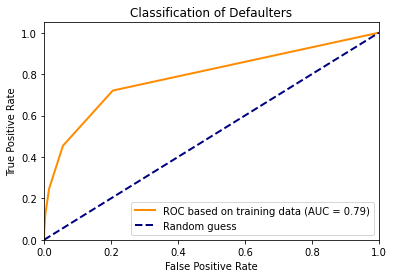

In [335]:
# Plot of the Roc curve and AUC using a function from my module (customplots) in the validation data
roc_curve_plot(val_y, predictions[:,1])

Now I fit this basic model with the full data (no validation data)

In [22]:
model_knn_bl.fit(X_train, y)
y_train_hat_knn_bl = model_knn_bl.predict_proba(X_train)

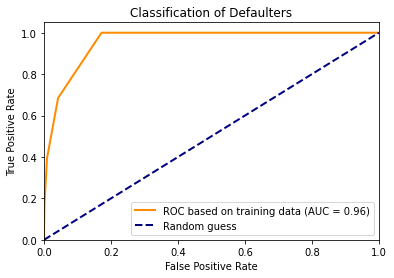

In [23]:
roc_curve_plot(y, y_train_hat_knn_bl[:,1])

Note the huge difference of the AUC when predicts observed data and when there were not observed data. This overfitting is expected since we haven't started to find the best paramenters of the knn model.

Lets send predicictions of this basic model to kaggle to have some information from the leaderboard.

In [25]:
y_test_hat_knn_bl = model_knn_bl.predict_proba(X_test)

test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_bl[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_bl.csv", index = False)

The score of these predictions in the public leaderboard of the competence in the same as the cross-validated AUC score. 
This is a good sign that shows that the validation process that I am following is right. Lets start improving the model by incluiding class imbalance and hyperparamenter tunning. 

## A better approach -  Class imbalance and hyperparameter tunning

Henceforth, I will try to improve the predictions by searching a way to del with the class imbalance and by doing hyperparameter tunning over the number of neighbors, the distance and if the distance is weighted.

### Class imbalance

Since the KNN class from Sklearn do not have any parameter to manage the class imbalance of the data I will use the library imblearn, which includes several algorithms of under sampling and over sampling to deal with imbalanced datasets. The strategy to follow is simple, test with crosvalidation several approaches and choose the one that improves the AUC. I will also include my own class for reweight probabilities (as we saw in clas the last term).

In [13]:
# Import imblearn and the classes for undersampling
import imblearn
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule, TomekLinks

I coded the reweight probability class to include a option in which I choose if it have to reweight or not to include in the pipeline to compare performance of the model.

In [10]:
# List of undersamplig methos with default parameters
under_sampling = [RandomUnderSampler(random_state=123),
                  NearMiss(),
                  OneSidedSelection(random_state=123), 
                  NeighbourhoodCleaningRule(),
                  TomekLinks()]

# Class ReweightProba (as it was seen in the last term)
reweight = [ReweightProba(reweight=False), ReweightProba(reweight=True)]

The next function is a pipeline hat test the algorimg of under sampling from imblearn with and without reweight of probabilities. I included the f1 score to have more information about the performance of the models 

In [244]:
def class_imbalance_pipeline(model, classb_method, reweight_method):

    splitter = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

    fits_data = {}
    fits_data['method'] = []; fits_data['reweighted'] = []; fits_data['nrows'] = []; fits_data['auc'] = []; fits_data['f1'] = []

    for train_index, val_index in splitter.split(X_train, y):
        train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
        train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

        for method in classb_method:
            for j, adjust in enumerate(reweight_method):
                X_resampled, y_resampled = method.fit_resample(train_df, train_y) # Resampling only the training data
                
                model.fit(X_resampled, y_resampled) # Fitting over the resampled training dataset
                predictions = model.predict_proba(val_df) # predictions over the dataset for validation

                reweighted_transformer = adjust
                reweighted_transformer.fit(predictions[:,1], y.mean() ,0.5)
                predictions_a = reweighted_transformer.transform(predictions[:,1])

                # Save the information in a dictionary
                fits_data['method'].append(str(method)[:10])
                fits_data['reweighted'].append(j)
                fits_data['nrows'].append(X_resampled.shape[0])
                fits_data['auc'].append(roc_auc_score(val_y, predictions_a))
                fits_data['f1'].append(f1_score(val_y, (predictions_a > 0.5).astype(int)))

    return pd.DataFrame(fits_data)

model_knn_bl = KNeighborsClassifier()

df_fits_under = class_imbalance_pipeline(model_knn_bl, under_sampling, reweight)
df_fits_under.groupby(['method', 'reweighted'])['auc', 'f1'].mean()

auc        f1
method     reweighted                    
NearMiss() 0           0.809772  0.446022
           1           0.809772  0.289587
Neighbourh 0           0.833107  0.494112
           1           0.833107  0.259410
OneSidedSe 0           0.789187  0.364320
           1           0.789187  0.088269
RandomUnde 0           0.844075  0.448690
           1           0.844075  0.365706
TomekLinks 0           0.789260  0.364320
           1           0.789260  0.088269

The table above shows that the reweight of probabilities do not affect the auc (for that reason I included the F1) and the F1 score is better if I do not reweighted the probabilities.

Besides, according with the above table, the best strategy for dealing with class imbalance by the under-sampling approach is the Random undersampling. However this algorith's drawback is that is trained with same amount of rows whose target value is 1. This means that uses only around 12% of the training data.

Another good algorithm to use is the Neighborhood Cleaning Rule NCR (NeighbourhoodCleaningRule()), this method belongs to the family of Cleaning under-sampling techniques, which consist in clear the noisy observations of the dataset (cleaning the data) instead of create a balanced data. The method of NCR is show in the next table, it performs a process in which noisy rows are droped. 

The full explanation of NCR is available in https://sci2s.ugr.es/keel/pdf/algorithm/congreso/2001-Laurikkala-LNCS.pdf

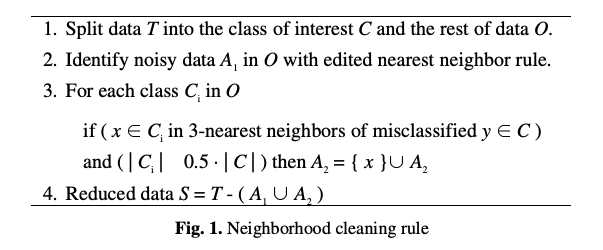

Lets see now how well a couple of algorithms for over sampling from imblearn work in constrast with the undersampling methods

In [14]:
# Classes for over samplig from imblearn
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN, ADASYN, BorderlineSMOTE

In [25]:
# Algorithm to use with default paramenters (only choose the radom_state)
over_sampling = [RandomOverSampler(random_state=123),
                 SMOTE(random_state=123),
                 ADASYN(random_state=123), 
                 BorderlineSMOTE(random_state=123)]

In [246]:
df_fits_over = class_imbalance_pipeline(model_knn_bl, over_sampling, reweight)
df_fits_over.groupby(['method', 'reweighted'])['auc', 'f1'].mean()

auc        f1
method     reweighted                    
ADASYN(ran 0           0.763994  0.271630
           1           0.763994  0.362083
Borderline 0           0.787103  0.292251
           1           0.787103  0.392064
RandomOver 0           0.783184  0.449111
           1           0.783184  0.433596
SMOTE(rand 0           0.772339  0.277340
           1           0.772339  0.372561

The table above shows that in this case, the reweight improves F1 score in all of the methods (shoud I use a different function to reweight if I do undersampling?). However the performance in both the AUC and the F1 is lower in all the methods of oversampling in constrast with undersampling.

According with the above, I will use the NCR method for under sampling. However I want to do a smalll grid search over the parameters of the NCR method to work with the best approach to balanced data possible.

#### Grid search over the choosen method for dealing with imbalanced classes

The next loop does grid search over a list of NeighbourhoodCleaningRule() classes with different values for number of neighbors and the method to select the row to eliminate from the data.

In [298]:
# List (with) names of the methods of NCR to fit over
NCR_gs = [('default', NeighbourhoodCleaningRule()),
                 ('k=1, sel=all', NeighbourhoodCleaningRule(n_neighbors = 1, kind_sel = "all")),
                 ('k=5, sel=all', NeighbourhoodCleaningRule(n_neighbors = 5, kind_sel = "all")),
                 ('k=10, sel=all', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")),
                 ('k=15, sel=all', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "all")),
                 ('k=20, sel=all', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "all")),
                 ('k=1, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 1, kind_sel = "mode")),
                 ('k=5, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 5, kind_sel = "mode")),
                 ('k=10, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "mode")),
                 ('k=15, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "mode")),
                 ('k=20, sel=mode', NeighbourhoodCleaningRule(n_neighbors = 20, kind_sel = "mode"))]

# The splitter is a stratifield k fold since we have imbalanced data
splitter = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)

# Dictionary to save results 
data = {}; data['Params'] = []; data['AUC'] = []

# Loop that splits the data into training and validation 5 times, for each method. It is a grid search made by hand.
for train_index, val_index in splitter.split(X_train, y):
        train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
        train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

        for name, method in NCR_gs:
            X_resampled, y_resampled = method.fit_resample(train_df, train_y)

            model_knn_bl.fit(X_resampled, y_resampled)
            predictions = model_knn_bl.predict_proba(val_df)
            
            data['Params'].append(name)
            data['AUC'].append(roc_auc_score(val_y, predictions[:,1]))
            
# Data and data.frame
df_fits_NCR = pd.DataFrame(data)
df_fits_NCR.groupby(['Params'])['AUC'].mean()

Params
default           0.833107
k=1, sel=all      0.811232
k=1, sel=mode     0.811232
k=10, sel=all     0.851447
k=10, sel=mode    0.850478
k=15, sel=all     0.849540
k=15, sel=mode    0.850478
k=20, sel=all     0.849540
k=20, sel=mode    0.849533
k=5, sel=all      0.841145
k=5, sel=mode     0.840507
Name: AUC, dtype: float64

The output from above shows that by selecting the undersampling method (NCR) with 10 neighbors and deleting the rows based on the class of all of the ten neighbors, improves mre the AUC of a simple (without tunned parameters) KNN algorithm.

In [264]:
model_knn_bl_r = KNeighborsClassifier()
resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")

print(X_train.shape, y.shape)
X_resampled, y_resampled = resampling_m1.fit_resample(X_train, y)
print(X_resampled.shape, y_resampled.shape)

(20885, 810) (20885,)
(17902, 810) (17902,)


Look that now the resampled training data have 17902 rows. As it was seen in the grid search to select the parameters of the undersamppling method, the crossvalidated value of AUC is 0.851447. Lets upload predicted probabilities of this model and seing if there is an improvement in the score in the public leaderboard.

In [268]:
y_test_hat_knn_bl_r = model_knn_bl_r.predict_proba(X_test)

test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_bl_r[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_bl_r.csv", index = False)

The new predictions score ≈0.80 in the leaderboard. Far from the ≈0.85 seen in the cross validated intern score. Now I want to do hyper parameter tunning over the parameters of the knn class of sklearn.

### Hyper parameter tunning

In this section using the undersampling method choosen above I will run a grid search to select the best paramenters of the KNN algorithm. Since the process is first fit a model in the resampled data and then predict over no-resampled test data the normal class of gridsearch does not work. For this reason I created my own loop to make the process more similar better.

In [299]:
parameters1 = {'n_neighbors' : [50, 100, 300, 600], 
               'weights' : ['uniform', 'distance'],
               'p': [1,2]}

results = {'n_neighbors' : [], 
           'weights' : [],
           'p': [],
           'AUC' : []}

from datetime import datetime
start_time = datetime.now()


resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")
splitter = StratifiedKFold(n_splits=4, random_state=123, shuffle=True, ) # Create 4 splits of the data

metrics = []
for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    X_resampled, y_resampled = resampling_m1.fit_resample(train_df, train_y)
    
    # From each split of the data iterate over all the the parameters
    for k in parameters1['n_neighbors']:
        for weight in parameters1['weights']:
            for p in parameters1['p']:
                model = KNeighborsClassifier(n_neighbors = k,
                                             weights = weight,
                                             algorithm = 'kd_tree', # The faster: the three algorithms give the same AUC
                                             p = p)
                model.fit(X_resampled, y_resampled)
                predictions = model.predict_proba(val_df)

                results['n_neighbors'].append(k)
                results['weights'].append(weight)
                results['p'].append(p)
                auc = roc_auc_score(val_y, predictions[:,1])
                results['AUC'].append(auc)
                print('k:', k, weight, 'p:', p, ' : ', auc)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

k: 50 uniform p: 1  :  0.8565403961047433
k: 50 uniform p: 2  :  0.8684683790652927
k: 50 distance p: 1  :  0.8656728212309497
k: 50 distance p: 2  :  0.8721817002328406
k: 100 uniform p: 1  :  0.8556373346270966
k: 100 uniform p: 2  :  0.8671391475496601
k: 100 distance p: 1  :  0.862376113895275
k: 100 distance p: 2  :  0.8696285392420091
k: 300 uniform p: 1  :  0.8536196887249631
k: 300 uniform p: 2  :  0.8635695370201912
k: 300 distance p: 1  :  0.8574985895407324
k: 300 distance p: 2  :  0.8647443990524654
k: 600 uniform p: 1  :  0.852337135600727
k: 600 uniform p: 2  :  0.8606502998259667
k: 600 distance p: 1  :  0.8550257374358861
k: 600 distance p: 2  :  0.8615452752830567
k: 50 uniform p: 1  :  0.8689417954353836
k: 50 uniform p: 2  :  0.8785279314902563
k: 50 distance p: 1  :  0.8773735231636421
k: 50 distance p: 2  :  0.8819834248244732
k: 100 uniform p: 1  :  0.8694051419125145
k: 100 uniform p: 2  :  0.8771056768687573
k: 100 distance p: 1  :  0.875818726045705
k: 100 dist

In [301]:
results_gs_knn1 = pd.DataFrame(results)
results_gs_knn1.groupby(['n_neighbors', 'weights', 'p'])['AUC'].mean().sort_values(ascending=False)

n_neighbors  weights   p
50           distance  2    0.876031
             uniform   2    0.872471
100          distance  2    0.872321
             uniform   2    0.869788
50           distance  1    0.868604
300          distance  2    0.866603
100          distance  1    0.866221
300          uniform   2    0.865211
600          distance  2    0.862877
             uniform   2    0.861789
50           uniform   1    0.860338
300          distance  1    0.860091
100          uniform   1    0.859843
300          uniform   1    0.856145
600          distance  1    0.855966
             uniform   1    0.853030
Name: AUC, dtype: float64

<AxesSubplot:xlabel='n_neighbors', ylabel='AUC'>

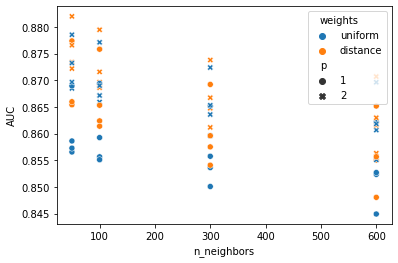

In [305]:
sns.scatterplot(x='n_neighbors', y='AUC', hue = 'weights',  style = 'p', data = results_gs_knn1)

From the graph above we see that the data adjust better the distance is reweighted according, and when the distance used is the euclidean distances (p = 2). Besides, the results improve as we decrease the number of neighbors.

Lets fit this model to send it to the kaggle competition.

In [306]:
# Initialization of model and resampling method
model_knn_m1 = KNeighborsClassifier(weights = 'distance', p = 2, n_neighbors = 50, algorithm = 'kd_tree')
resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")

# Getting the resample data
X_resampled, y_resampled = resampling_m1.fit_resample(X_train, y)

# FIt the model in the resampled data and get the predicted proba on this data
model_knn_m1.fit(X_resampled, y_resampled)

# Predict in the test data
y_test_hat_knn_m1 = model_knn_m1.predict_proba(X_test)

0.14288450488412183


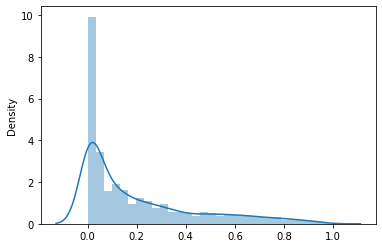

In [321]:
# Plot of the distribution of the predicted probabilities
sns.distplot(y_test_hat_knn_m1[:,1])
print((y_test_hat_knn_m1[:,1] > 0.5).astype(int).mean()) # proportion of predicted deads

The model with 50 neighbors predicts a 14% of dead patients in the test data (if p > 0.5), this is informative since is more than what we saw in the training data (without any adjustment for class imbalance). However, the metric to optimize is the AUC, and from the grid search we get into the conclution that this is the best fitting over a set of different 16 different models.

In [308]:
# Export the data
test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_m1[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_m1.csv", index = False)

The above model is better in the public leaderboard, but it is still far from the score observed here.

#### More grid search

We saw that on average the AUC increased in the left hand part of the graph. In this section I will try a new grid search only for number of neighbors (k) to get the best value for this parameter

In [311]:
# The next code is similar to the loops used before in this notebook
start_time = datetime.now()

resampling_m1 = NeighbourhoodCleaningRule(n_neighbors = 10, kind_sel = "all")
splitter = StratifiedKFold(n_splits=4, random_state=123, shuffle=True, )

parameters2 = {'n_neighbors' : [10, 20, 30, 40, 50, 60, 80, 100]}

results = {'n_neighbors' : [], 
           'AUC' : []}

for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    X_resampled, y_resampled = resampling_m1.fit_resample(train_df, train_y)
    
    for k in parameters2['n_neighbors']:
        model = KNeighborsClassifier(n_neighbors = k,
                                     weights = 'distance',
                                     algorithm = 'kd_tree',
                                     p = 2)
        model.fit(X_resampled, y_resampled)
        predictions = model.predict_proba(val_df)

        results['n_neighbors'].append(k)
        auc = roc_auc_score(val_y, predictions[:,1])
        results['AUC'].append(auc)
        print('k: ', k, 'AUC: ', auc)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

k:  10 AUC:  0.8709371881598607
k:  20 AUC:  0.8751555180658239
k:  30 AUC:  0.8742862708559604
k:  40 AUC:  0.8731523902460538
k:  50 AUC:  0.8721817002328406
k:  60 AUC:  0.8721896024802032
k:  80 AUC:  0.8699143065594166
k:  100 AUC:  0.8696285392420091
k:  10 AUC:  0.8780866754291985
k:  20 AUC:  0.8811027535703636
k:  30 AUC:  0.8843191181505904
k:  40 AUC:  0.8843272179698172
k:  50 AUC:  0.8819834248244732
k:  60 AUC:  0.8812179919075442
k:  80 AUC:  0.8800460953348723
k:  100 AUC:  0.8794695354753674
k:  10 AUC:  0.8694148985129467
k:  20 AUC:  0.8750440887887457
k:  30 AUC:  0.8751381571438565
k:  40 AUC:  0.8734579969147053
k:  50 AUC:  0.8733876757568728
k:  60 AUC:  0.8726117498923094
k:  80 AUC:  0.8692291549311332
k:  100 AUC:  0.8686148572775034
k:  10 AUC:  0.8697416525840264
k:  20 AUC:  0.8744310797427203
k:  30 AUC:  0.8752743813763065
k:  40 AUC:  0.876163152449643
k:  50 AUC:  0.8765727455809963
k:  60 AUC:  0.874777531101465
k:  80 AUC:  0.8733427585775244
k:  100

In [319]:
results_gs_knn1 = pd.DataFrame(results)
results_gs_knn1.groupby('n_neighbors').agg({'AUC': ['mean', 'var']})

AUC          
                 mean       var
n_neighbors                    
10           0.872045  0.000017
20           0.876433  0.000010
30           0.877254  0.000022
40           0.876775  0.000027
50           0.876031  0.000019
60           0.875199  0.000017
80           0.873133  0.000024
100          0.872321  0.000024

Lets train a model with the full trained (and undersampled) data to send predictions to the kaggle competition. 

In [329]:
# Initialization of model
model_knn_m2 = KNeighborsClassifier(weights = 'distance', p = 2, n_neighbors = 30, algorithm = 'kd_tree')

# Fit the model in the resampled data and get the predicted proba on this data
model_knn_m2.fit(X_resampled, y_resampled)

# Predict in the test data
y_test_hat_knn_m2 = model_knn_m2.predict_proba(X_test)

0.15897337674774947


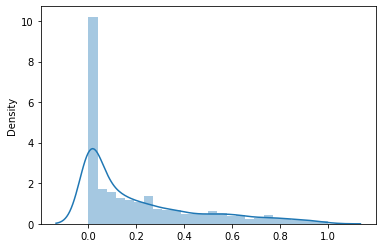

In [330]:
# Plot of the distribution of the predicted probabilities
sns.distplot(y_test_hat_knn_m2[:,1])
print((y_test_hat_knn_m2[:,1] > 0.5).astype(int).mean()) # proportion of predicted deads

In [331]:
# Export the data
test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_m2[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_m2.csv", index = False)

### Second approach to deal with class imbalance: Calibrated probabilities

In his link https://machinelearningmastery.com/probability-calibration-.for-imbalanced-classification/ they explain another approach to manage the class imbalance. According with the post:

***"...the probabilities or probability-like scores predicted by many models are not calibrated. This means that they may be over-confident in some cases and under-confident in other cases. Worse still, the severely skewed class distribution present in imbalanced classification tasks may result in even more bias in the predicted probabilities as they over-favor predicting the majority class.***

***As such, it is often a good idea to calibrate the predicted probabilities for nonlinear machine learning models prior to evaluating their performance. Further, it is good practice to calibrate probabilities in general when working with imbalanced datasets, even of models like logistic regression that predict well-calibrated probabilities when the class labels are balanced."***

In this section I will test this approach over the best knn model so far.

In [98]:
# Libraries for calibrate probabilities
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold

In [421]:
# Insert the model in the calibrated probabilities method
calib_knn_m2 = CalibratedClassifierCV(model_knn_m2)

# Define the grid to search over in the calibration method
param_gs_calib1 = dict(cv=[2,3,4], method=['sigmoid','isotonic'])

# Define the validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Grid serach
gs_calib1  = GridSearchCV(estimator=calib_knn_m2, 
                          param_grid=param_gs_calib1, 
                          n_jobs=-1, 
                          cv=cv, 
                          scoring='roc_auc',
                          verbose=3)

In [422]:
start_time = datetime.now()
gs_calib1_results = gs_calib1.fit(X_resampled, y_resampled)
print('Duration: {}'.format(end_time - start_time))

Fitting 30 folds for each of 6 candidates, totalling 180 fits
Duration: -1 day, 9:39:24.953435


In [424]:
print("Best: %f using %s" % (gs_calib1_results.best_score_, gs_calib1_results.best_params_))

Best: 0.931297 using {'cv': 4, 'method': 'isotonic'}


In [428]:
# Getting the probabilities from the best configuration of calibrated probabilities

# Calibrated probabilities of the best model
knn_m2_cali_obj = CalibratedClassifierCV(model_knn_m2, cv = 4, method = 'isotonic')
knn_m2_cali_obj.fit(X_resampled, y_resampled)

CalibratedClassifierCV(base_estimator=KNeighborsClassifier(algorithm='kd_tree',
                                                           n_neighbors=30,
                                                           weights='distance'),
                       cv=4, method='isotonic')

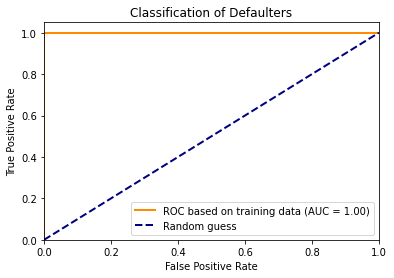

In [429]:
y_train_hat_knn_m2_cali = knn_m2_cali_obj.predict_proba(X_resampled)
roc_curve_plot(y_resampled, y_train_hat_knn_m2_cali[:,1])

The graph above is the AUC of the model over previusly seen observation wich is not somethin I shoul take into account. The reference score here is the 0.93 seen in the gridsearch

<AxesSubplot:ylabel='Density'>

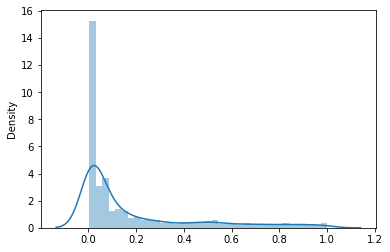

In [430]:
y_test_hat_knn_m2_cali = knn_m2_cali_obj.predict_proba(X_test)
sns.distplot(y_test_hat_knn_m2_cali[:,1])

In [431]:
# Export the data
test_predictions_submit = pd.DataFrame({"icustay_id": test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_knn_m2_cali[:,1]})
test_predictions_submit.to_csv("data/outputs/knn_m2_cal.csv", index = False)

With all of the above I have applied a class balace strategy and doing and hyperparameter tunning, which gets me into the best possible model according to the pre-processing  data made. At this point I improved my internal measurement of AUC from around 0.80 to a 0.93. Based on the kaggle public leaderboard my results improved from 0.79 on average to 0.87

The next section focus on fitting models with another algorithm that should get better results.

# Support Vector Machines (SVM)

In this section a will show the process of fitting support vector machines (SVM) over my data. Usuaaly this kind of models are stronger than KNN models. 

I will start as before with KNN by running a baseline model (the most basic one) and then try to improve the observed AUC with hyperparameter tunning and classs imbalance approaches.


## SVM base line model

In [16]:
from sklearn.svm import SVC

In [343]:
# Fist model with default parameters but of type lineal (the most basic one) and with probabilities

model_svm_bl = SVC(kernel='linear', probability=True)
splitter = StratifiedKFold(n_splits=5, random_state=None, shuffle=True)

metrics = []

start_time = datetime.now()
# Split train data into train and validation to predict over unobserved data
for train_index, val_index in splitter.split(X_train, y):
    train_df, val_df = X_train.iloc[train_index], X_train.iloc[val_index] 
    train_y, val_y = y.iloc[train_index], y.iloc[val_index] 

    model_svm_bl.fit(train_df, train_y)
    predictions = model_svm_bl.predict_proba(val_df)
    metrics.append(roc_auc_score(val_y, predictions[:,1]))
    
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

print(metrics)
print(mean(metrics))

Duration: 1:07:27.926018
[0.9592260610953554, 0.9619102821537252, 0.9569041063751975, 0.955663775436272, 0.9650878754631833]


NameError: name 'mean' is not defined

In [344]:
print(metrics)
print(np.mean(metrics))

[0.9592260610953554, 0.9619102821537252, 0.9569041063751975, 0.955663775436272, 0.9650878754631833]
0.9597584201047467


The average of this model is an AUC 0.96. Much better that using the basic KNN. The following in the ROC of the last fit in the loop from above

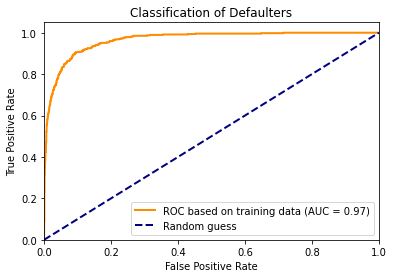

0.7281437125748504


In [349]:
#Plot of the Roc curve and AUC using the last split of the data and predictions from above
roc_curve_plot(val_y, predictions[:,1])
print(f1_score(val_y, (predictions[:,1] > 0.5).astype(int)))

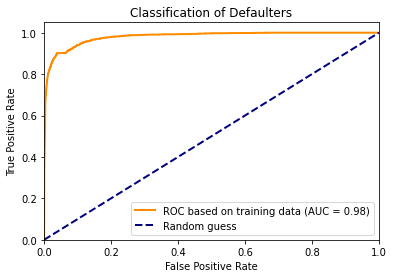

0.8234735091470659


In [351]:
model_svm_bl.fit(X_train, y)
y_train_hat_svm_bl = model_svm_bl.predict_proba(X_train)

# Roc curve and auc over all the training data
roc_curve_plot(y, y_train_hat_svm_bl[:,1])
print(f1_score(y, (y_train_hat_svm_bl[:,1] > 0.5).astype(int)))

So far the model looks good according with the AUC score, however there is a large difference in the F1 score between a model fitting in validation and data and the predictions over the whole training data. This is something that I want to avoid. Now onwards, I will take into account multiple metrics to choose the best model.

In [347]:
# Predictions in text data to upload them to kaggle
y_test_hat_svm_bl = model_svm_bl.predict_proba(X_test)

test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_bl[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_bl.csv", index = False)

#### How good is the base SVM over the resampled data

Since SVM takes too long to run I want to try to use a reduced version of my data. For this reason I will run the baseline model over a resampled version of my training data(from the Knn models) to compare running time as well as performance.

In [17]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score

In [436]:
# Running a base line model over the resampled data
# Since hear we have less rows in should take less time to run


print(X_resampled.shape, X_train.shape)

model_svm_bl = SVC(kernel='linear', probability=True)

start_time = datetime.now()

# I have forgotten that my own loop is not efficient since it only uses 1 core to process. inbuilt sklearn functions are better
svm_bl_r_s = cross_val_score(model_svm_bl, X_resampled, y_resampled, cv = 5, n_jobs = - 1, verbose = 1, scoring = 'roc_auc')

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))


(11279, 810) (20885, 810)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min


Duration: -1 day, 7:34:36.197798
[0.962640868507425, 0.9594287222566503, 0.9658243246344879, 0.9691959879731001, 0.9701163671417752, 0.9570010326482818, 0.9404844576719577]
0.9606702515476683


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.0min finished


In [438]:
#Plot of the Roc curve and AUC using the last split of the data and predictions from above
np.mean(svm_bl_r_s)

0.9711174497479643

This is slighly better, however i did not ckeck running time. Lets see the performance of this baseline model in the resampled data to get information of the performance improvement.

In [439]:
# Predictions in text data to upload them to kaggle
model_svm_bl_re = SVC(kernel='linear', probability=True)
model_svm_bl_re.fit(X_resampled, y_resampled)

y_test_hat_svm_bl_re = model_svm_bl_re.predict_proba(X_test)

test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_bl_re[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_bl_re.csv", index = False)

These predictions using the resampled data score lower than the complete data (0.81 vs 0.83). These results also show a higher overfiting.  It can make sence since the resampled data was optimized for a KNN algorithm.

## Finding a better linear SVM 

In this section I will use the LinearSVC class from sklearn.svm. According with the documentation this class uses another method for computing the support vector machines that is faster, and it is the suggested option when we want to fit linear SVMs.

The drawback of this class is that by default it does not have the option to predict probabilities. However, I can use the Calibrated probabilities method used in KNN to get the them.

I will start by doing a grid search that takes into account multiple metrics and them I will compute the probabilities of the best model.

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.svm import LinearSVC

In [13]:
# Grid search
svm_params_1 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 3, 5, 10, 50, 100],
                'loss': ['hinge', 'squared_hinge']}

svm_gs1 = GridSearchCV(LinearSVC(class_weight = 'balanced'),
                       param_grid = svm_params_1,
                       scoring = ['balanced_accuracy','accuracy','roc_auc', 'f1'],
                       n_jobs = 7,
                       cv=10,
                       refit = False,
                       verbose = 2)

In [397]:
# Fitting the grid search
start_time = datetime.now()
svm_gs1_fit = svm_gs1.fit(X_train, y)
print('Duration: {}'.format(end_time - start_time))

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Duration: -1 day, 10:59:09.148123


In [447]:
# Saving the results of the grid search as a dataframe
df_results_svm_gs1 = pd.DataFrame(svm_gs1_fit.cv_results_)

<AxesSubplot:xlabel='param_C', ylabel='mean_test_balanced_accuracy'>

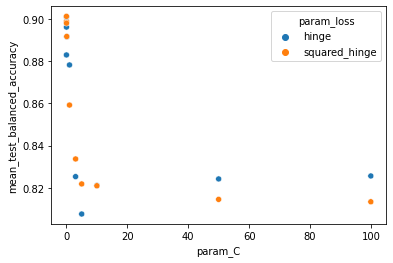

In [445]:
# Plot of grid search results for balanced accuracy
sns.scatterplot(x = 'param_C', y = 'mean_test_balanced_accuracy', hue = 'param_loss', data = df_results_svm_gs1)

<AxesSubplot:xlabel='param_C', ylabel='mean_test_balanced_accuracy'>

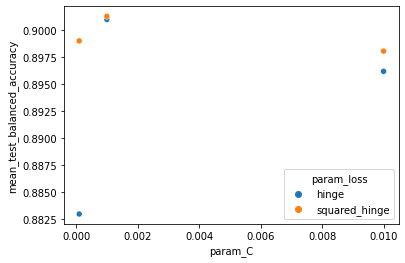

In [451]:
# Zoomed plot for the lowest values for C in balanced accuracy 
filter_df_1 = df_results_svm_gs1[df_results_svm_gs1['param_C']<0.1]
sns.scatterplot(x = 'param_C', y = 'mean_test_balanced_accuracy', hue = 'param_loss', data = filter_df_1)

<AxesSubplot:xlabel='param_C', ylabel='mean_test_roc_auc'>

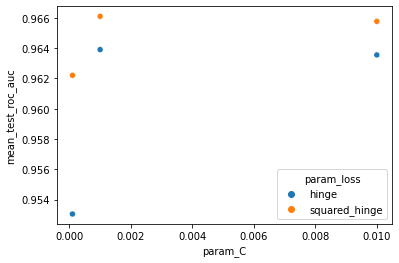

In [452]:
# Zoomed plot for the lowest values for C in mean_test_roc_auc
sns.scatterplot(x = 'param_C', y = 'mean_test_roc_auc', hue = 'param_loss', data = filter_df_1)

From the results above we see that the best linear suport vector machine classifier uses C = 0.001 and the squared_hinge function as the loss approach. 

What it is good from the class LinearSVC is that the running time is much lower than the SCV, however it does not compute probabilities. An strategy to find probabilites from the best fitting is to use the class CalibratedClassifierCV from skelarn as follows.

The code below all runs a grid search to find the best parameters to computed the calibrated probabilities.

In [470]:
# Insert the model in the calibrated probabilities method
calib_smv_m1 = CalibratedClassifierCV(LinearSVC(C = 0.001, loss = 'squared_hinge'))

# Define the grid to search over in the calibration method
param_gs_calib1 = dict(cv=[3,4,5,7,8,10,12,15], method=['sigmoid','isotonic'])

# Define the validation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

# Grid serach
gs_calib1_svm  = GridSearchCV(estimator=calib_smv_m1, 
                          param_grid=param_gs_calib1, 
                          n_jobs=-1, 
                          cv=cv, 
                          scoring='roc_auc',
                          verbose=3)

In [471]:
start_time = datetime.now()
gs_calib1_svm_res = gs_calib1_svm.fit(X_train, y)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 30 folds for each of 16 candidates, totalling 480 fits
Duration: 0:12:17.711790


In [472]:
print("Best: %f using %s" % (gs_calib1_svm_res.best_score_, gs_calib1_svm_res.best_params_))

Best: 0.967378 using {'cv': 12, 'method': 'sigmoid'}


Although I have done hyperparameter tunning over the SVM algorith and the method for computing and calibrating probabilities, the AUC is still 0.96, which is not better from the basic SVM.

Lets fit the model over the complete training data and upload probabilities to the kaggle competition.

In [473]:
svm_m1_cali_obj = CalibratedClassifierCV(LinearSVC(C = 0.001, loss = 'squared_hinge'), cv = 12, method = 'sigmoid')
svm_m1_cali_obj.fit(X_train, y)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.001), cv=12)

<AxesSubplot:ylabel='Density'>

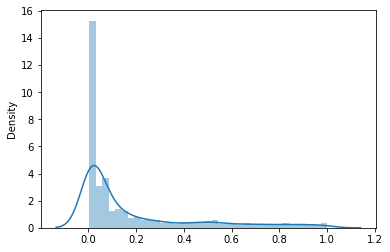

In [474]:
y_test_hat_svm_m1_cali = svm_m1_cali_obj.predict_proba(X_test)
sns.distplot(y_test_hat_knn_m2_cali[:,1])

In [475]:
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m1_cali[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m1_cal.csv", index = False)

In the public leaderboard the last model do shows an improvement in the AUC. Now I want to run another grid search to check if the inclusion of the paramenter of the linear SVM to take into account the imbalanced feature of the data improves or not the scores.

### More grid search over  Linear SVM

In [58]:
# SVM approaches
svm_params_2 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50],
                #'penalty' : ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'class_weight' : [None, 'balanced']}

# Dictionary to save results
results = {}
results['C'] = [];  results['loss'] = [];
results['class_weight'] = []; results['mean_auc'] = []


# Loop 
start_time = datetime.now()
for C in svm_params_2['C']:
    for loss in svm_params_2['loss']:
        for reweigth in svm_params_2['class_weight']:
            model = LinearSVC(C = C, loss = loss, class_weight = reweigth)

            calibrated = CalibratedClassifierCV(model, method='isotonic', cv=3) 
            cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
            scores = cross_val_score(calibrated, X_train, y, scoring='roc_auc', cv=cv, n_jobs=-1)
            mean_score = np.mean(scores)

            print('C:', C, loss, str(reweigth), ':', mean_score)
            results['C'].append(C);  results['loss'].append(loss)
            results['mean_auc'].append(mean_score); results['class_weight'].append(reweigth)

end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

df_gs_svm2 = pd.DataFrame(results)

C: 0.0001 hinge None : 0.947283574784837
C: 0.0001 hinge balanced : 0.950025867048234
C: 0.0001 squared_hinge None : 0.9588745132569297
C: 0.0001 squared_hinge balanced : 0.9610404466007647
C: 0.001 hinge None : 0.9611175641820137
C: 0.001 hinge balanced : 0.9638641454145598
C: 0.001 squared_hinge None : 0.9664471805177351
C: 0.001 squared_hinge balanced : 0.9666353808632723
C: 0.01 hinge None : 0.9654032273462948
C: 0.01 hinge balanced : 0.9646288858116077
C: 0.01 squared_hinge None : 0.9675397028808284
C: 0.01 squared_hinge balanced : 0.9664289721795056
C: 0.1 hinge None : 0.9650497176139835
C: 0.1 hinge balanced : 0.9631300231829277
C: 0.1 squared_hinge None : 0.9663657319538796
C: 0.1 squared_hinge balanced : 0.9651354281733682
C: 1 hinge None : 0.962725455165952
C: 1 hinge balanced : 0.9621110838759281
C: 1 squared_hinge None : 0.9632873639082755
C: 1 squared_hinge balanced : 0.9619399664964746
C: 5 hinge None : 0.957088195859742
C: 5 hinge balanced : 0.9574887887824263
C: 5 squar

In [71]:
df_gs_svm2.sort_values(by = 'mean_auc', ascending=False).head(5)

,C,loss,class_weight,mean_auc
10,0.010,squared_hinge,None,0.967540
7,0.001,squared_hinge,balanced,0.966635
6,0.001,squared_hinge,None,0.966447
11,0.010,squared_hinge,balanced,0.966429
14,0.100,squared_hinge,None,0.966366


<AxesSubplot:xlabel='C', ylabel='mean_auc'>

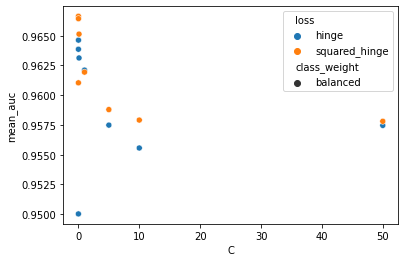

In [72]:
sns.scatterplot(x = 'C', y = 'mean_auc', hue = 'loss', style = 'class_weight', data = df_gs_svm2)

The best model dot not include the option balanced. However the differencess of the average AUC are so low in most of the adjusments. Lets upload predicted probabilities to kaggle

In [73]:
svm_m2_cali_obj = CalibratedClassifierCV(LinearSVC(C = 0.001, loss = 'squared_hinge', class_weight = None), method='isotonic', cv=3) 
svm_m2_cali_obj.fit(X_train, y)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.001), cv=3,
                       method='isotonic')

<AxesSubplot:ylabel='Density'>

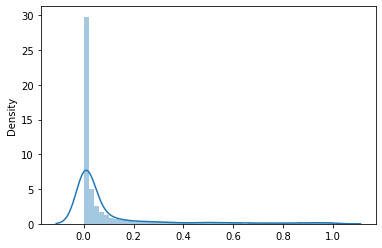

In [74]:
y_test_hat_svm_m2_cali = svm_m2_cali_obj.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m2_cali[:,1])

In [75]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m2_cali[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m2_cal.csv", index = False)

### Pipeline to find best Linear SVM (hyperparamenters) resampled method and 

This new grid search aims to include everything that I have tested so far: 1) Hyperameters of the linear SVM and 2) different under sampline approaches.

Since, this taks implies running hundreds of different fits and since I need to perform cross validation, I can't use the normal class of grid search. I will try to improve computing performance by configuring the next loop with multiprocessing over different cores of the machine.

In [20]:
# Multiprocessing library to use 5 cores of my computed (one for each fold in cross validation)
import multiprocessing
from multiprocessing.pool import ThreadPool as Pool

from sklearn.model_selection import train_test_split

In [18]:
# SVM approaches
svm_params_2 = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 200, 500],
                #'penalty' : ['l1', 'l2'],
                'loss': ['hinge', 'squared_hinge'],
                'class_weight' : [None, 'balanced']}

# Dictionary to save results
results = {}
results['C'] = [];  results['loss'] = [];
results['class_weight'] = []; results['mean_auc'] = []; results['resampling'] = []


# Class to split the data into train and validation, resample, and calibrate probabilities
# This class returns the computed AUC
class own_cv():
    def __init__(self, model_, resampling_):
        self.model_ = model_
        self.resampling_ = resampling_
    
    def fit(self, step):
        
        X_train_gs, X_val_gs, y_train_gs, y_val_gs = train_test_split(X_train, y, test_size=0.25)
        X_train_resampled_gs, y_train_resampled_gs = self.resampling_.fit_resample(X_train_gs, y_train_gs)

        calibrated = CalibratedClassifierCV(self.model_, method='isotonic', cv=3) 
        calibrated.fit(X_train_resampled_gs, y_train_resampled_gs)
        proba = calibrated.predict_proba(X_val_gs)
        auc = roc_auc_score(y_val_gs, proba[:,1])

        return auc


# Loop over each of the parameters to test
start_time = datetime.now()
for C in svm_params_2['C']:
    for loss in svm_params_2['loss']: 
        for reweigth in svm_params_2['class_weight']:
            for resampling in under_sampling:
                
                try:
                    model = LinearSVC(C = C, loss = loss, class_weight = reweigth)
                    # 5 times the class own_cv (cross validation) using different cores
                    if __name__ == '__main__':
                        pool = Pool(5)    

                        iter_n = range(0,5)
                        cv_class = own_cv(model, resampling)
                        scores = pool.map(cv_class.fit, iter_n)
                        pool.terminate()
                    
                    mean_score = np.mean(scores)
                    print('C:', C, loss, str(reweigth),  '[', str(resampling)[:12], ']' ,':', mean_score)
                    results['C'].append(C);  results['loss'].append(loss); results['mean_auc'].append(mean_score)
                    results['class_weight'].append(reweigth); results['resampling'].append(str(resampling)[:12])

                except:
                    pass
                
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

df_gs_svm2 = pd.DataFrame(results)

C: 0.0001 hinge None [ RandomUnderS ] : 0.9163898406568618
C: 0.0001 hinge None [ NearMiss() ] : 0.8559783872792822
C: 0.0001 hinge None [ Neighbourhoo ] : 0.9434824738819054
C: 0.0001 hinge None [ TomekLinks() ] : 0.9457598180646494
C: 0.0001 hinge balanced [ RandomUnderS ] : 0.9151535470235551
C: 0.0001 hinge balanced [ NearMiss() ] : 0.8564604937731433
C: 0.0001 hinge balanced [ OneSidedSele ] : 0.9471699161555083
C: 0.0001 hinge balanced [ Neighbourhoo ] : 0.9436621300632518
C: 0.0001 hinge balanced [ TomekLinks() ] : 0.945419907437698
C: 0.0001 squared_hinge None [ RandomUnderS ] : 0.9425473209476456
C: 0.0001 squared_hinge None [ NearMiss() ] : 0.8645579178601274
C: 0.0001 squared_hinge None [ Neighbourhoo ] : 0.9546036856610858
C: 0.0001 squared_hinge None [ TomekLinks() ] : 0.9586960877392638
C: 0.0001 squared_hinge balanced [ RandomUnderS ] : 0.9428707830000469
C: 0.0001 squared_hinge balanced [ NearMiss() ] : 0.8754588635108351
C: 0.0001 squared_hinge balanced [ Neighbourhoo 

C: 100 hinge None [ NearMiss() ] : 0.8741421590000694
C: 100 hinge None [ Neighbourhoo ] : 0.956893420504801
C: 100 hinge None [ TomekLinks() ] : 0.954641168305961
C: 100 hinge balanced [ RandomUnderS ] : 0.9421460077564211
C: 100 hinge balanced [ NearMiss() ] : 0.8752545673203687
C: 100 hinge balanced [ Neighbourhoo ] : 0.9568400106269423
C: 100 hinge balanced [ TomekLinks() ] : 0.9591499339485949
C: 100 squared_hinge None [ RandomUnderS ] : 0.9433492435295914
C: 100 squared_hinge None [ NearMiss() ] : 0.8707277057458409
C: 100 squared_hinge None [ Neighbourhoo ] : 0.9568743090768954
C: 100 squared_hinge None [ TomekLinks() ] : 0.9557595475592372
C: 100 squared_hinge balanced [ RandomUnderS ] : 0.9419037042506119
C: 100 squared_hinge balanced [ NearMiss() ] : 0.8824035052640307
C: 100 squared_hinge balanced [ Neighbourhoo ] : 0.9563328711510796
C: 100 squared_hinge balanced [ TomekLinks() ] : 0.9536095253605141
C: 200 hinge None [ RandomUnderS ] : 0.9403129749216841
C: 200 hinge None 

<AxesSubplot:xlabel='C_log', ylabel='mean_auc'>

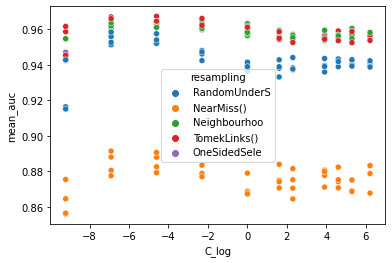

In [22]:
df_gs_svm2['C_log'] = np.log(df_gs_svm2['C'])
sns.scatterplot(x = 'C_log', y = 'mean_auc', hue = 'resampling', ,data = df_gs_svm2)

In [23]:
df_gs_svm2.sort_values(by = 'mean_auc', ascending=False)

,C,loss,class_weight,mean_auc,resampling,C_log
45,0.0100,squared_hinge,None,0.967372,TomekLinks(),-4.605170
28,0.0010,squared_hinge,None,0.967046,TomekLinks(),-6.907755
63,0.1000,squared_hinge,None,0.966188,TomekLinks(),-2.302585
32,0.0010,squared_hinge,balanced,0.966042,TomekLinks(),-6.907755
61,0.1000,squared_hinge,None,0.965228,OneSidedSele,-2.302585
...,...,...,...,...,...,...
78,1.0000,squared_hinge,None,0.867283,NearMiss(),0.000000
10,0.0001,squared_hinge,None,0.864558,NearMiss(),-9.210340
113,10.0000,squared_hinge,None,0.864470,NearMiss(),2.302585
5,0.0001,hinge,balanced,0.856460,NearMiss(),-9.210340


From the table above we see that the best undersampling method is the TomekLinks. With this undersampling method the best hyperaparameters for the Linear AVM are the same as the previous grid searches. Now lets fit this best model to upload the probabilities to kaggle.

In [23]:
# Fitting the best model to upload 

best_svm_resampling = TomekLinks()
X_resampled_svm, y_resampled_svm = best_svm_resampling.fit_resample(X_train, y)

model = LinearSVC(C = 0.01,  class_weight = None, loss = 'squared_hinge')

svm_m3_cali_obj = CalibratedClassifierCV(model, method='isotonic', cv=3) 
svm_m3_cali_obj.fit(X_resampled_svm, y_resampled_svm)

CalibratedClassifierCV(base_estimator=LinearSVC(C=0.01), cv=3,
                       method='isotonic')

<AxesSubplot:ylabel='Density'>

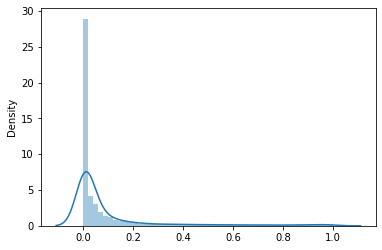

In [24]:
# Probabilities for the test data
y_test_hat_svm_m3_cali = svm_m3_cali_obj.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m3_cali[:,1])

In [25]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m3_cali[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m3_cal.csv", index = False)

These last predictions decrease in the public leaderboard the AUC compared with the model in which I only did hyperparamenter tunning over the Linear SVM. 

This shows that the resampling method for SVM does not work as well as in the KNN model.

Now I want to test other non linear kernels for the Support Vector machines

### Trying a different kernel of SVM: Radial basis function RBF

The radial basis function of the SVM is useful when we do not have linearly separable features. This is an option that I have to try 

In [29]:
# Baseline model with rbf kernel

model_svm_bl_rbf = SVC(kernel='rbf', probability=True, class_weight='balanced')

# Get the predicted proba by cross validation to measure the expeted AUC
model_svm_bl_rbf_proba = cross_val_predict(model_svm_bl_rbf, 
                                           X_train, 
                                           y, 
                                           cv = 5, 
                                           n_jobs = -1, 
                                           method='predict_proba',
                                           verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  7.6min remaining: 11.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  7.9min finished


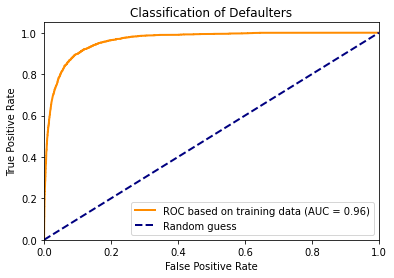

In [31]:
roc_curve_plot(y, model_svm_bl_rbf_proba[:,1])

The AUC from a cross valiation run is the same as the one seen in linear SVM. Lets predict probabilities in the test data and see the AUC score in the leaderboard of kaggle

<AxesSubplot:ylabel='Density'>

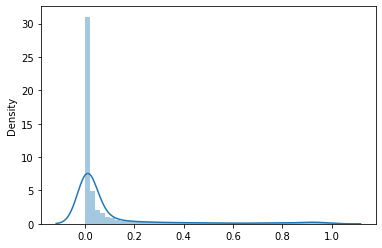

In [32]:
model_svm_bl_rbf.fit(X_train, y)
y_test_hat_svm_m4_rbf = model_svm_bl_rbf.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m4_rbf[:,1])

In [33]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m4_rbf[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m4_rbf.csv", index = False)

Now lets perform a grid search in order to find a better model for the radial kernel

In [43]:
svm_params_2 = {'C': [0.01, 0.1, 1, 3, 5, 10],
                 'gamma' : ['scale', 'auto']}

svm_gs2 = GridSearchCV(SVC(kernel='rbf', class_weight = 'balanced'),
                       param_grid = svm_params_2,
                       scoring = 'roc_auc',
                       n_jobs = -1,
                       cv=5,
                       refit = False,
                       verbose = 2)

In [44]:
svm_gs2.fit(X_train, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced'), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 3, 5, 10],
                         'gamma': ['scale', 'auto']},
             refit=False, scoring='roc_auc', verbose=2)

In [46]:
svm_gs2.best_params_

{'C': 3, 'gamma': 'auto'}

In [ ]:
According to the above, the C 4 with a gamma auto is the best predictor with a expected value of for the AUC

In [48]:
df_results_svm_gs2 = pd.DataFrame(svm_gs2.cv_results_)
df_results_svm_gs2.sort_values(by = 'mean_test_score', ascending=False).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,param_gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
7,195.355233,7.001585,28.274850,1.558936,3,auto,"{'C': 3, 'gamma': 'auto'}",0.956699,0.960659,0.966621,0.970480,0.968689,0.964630,0.005164,1
6,206.293698,6.179549,28.225191,0.822590,3,scale,"{'C': 3, 'gamma': 'scale'}",0.956439,0.960317,0.966326,0.970367,0.968314,0.964353,0.005190,2
9,214.883455,3.652149,27.883238,0.572359,5,auto,"{'C': 5, 'gamma': 'auto'}",0.956159,0.959291,0.966286,0.971032,0.968018,0.964157,0.005556,3
8,222.126005,6.833517,28.069163,1.310698,5,scale,"{'C': 5, 'gamma': 'scale'}",0.955883,0.958997,0.966068,0.970840,0.967560,0.963870,0.005560,4
11,171.642868,14.871485,14.772684,0.552927,10,auto,"{'C': 10, 'gamma': 'auto'}",0.955577,0.958653,0.965930,0.970967,0.967060,0.963638,0.005666,5


<AxesSubplot:ylabel='Density'>

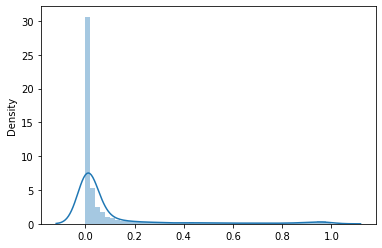

In [54]:
# Lets fit this model in the entire data and export the predictions

model_svm_m1_rbf = SVC(kernel='rbf', probability=True, class_weight='balanced', C = 3, gamma = 'auto')

model_svm_m1_rbf.fit(X_train, y)
y_test_hat_svm_m5_rbf = model_svm_m1_rbf.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m5_rbf[:,1])

In [55]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m5_rbf[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m5_rbf.csv", index = False)

Lets calibrate the probabilities of the best model from radial kernel.

In [58]:
calibrated = CalibratedClassifierCV(model_svm_m1_rbf, method='isotonic', cv=3) 
model_svm_m5_rbf_proba_cal = cross_val_predict(calibrated,
                          X_train, 
                          y,
                          cv = 5,
                          n_jobs=-1,
                          method='predict_proba') 

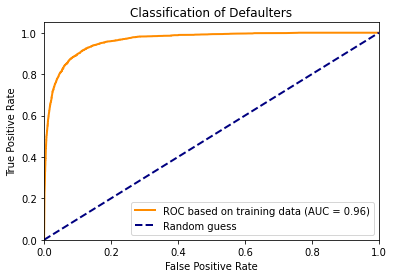

In [59]:
roc_curve_plot(y, model_svm_m5_rbf_proba_cal[:,1])

After the calibration of the probabilities the AUC is the same that the observed before

<AxesSubplot:ylabel='Density'>

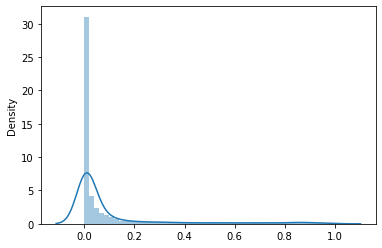

In [60]:
calibrated.fit(X_train, y)
y_test_hat_svm_m5_rbf_cal = calibrated.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m5_rbf_cal[:,1])

In [61]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m5_rbf_cal[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m5_rbf_cal.csv", index = False)

### Trying a different kernel of SVM: Sigmoid

Now I will try a third kernel, the Sigmoid that it has been said is like a basic Neuronal Network. 

In this section I will run a basic SVM with sigmoid kernel and then I will do grid search and calibrate probabilities. In the process I will observer the improvement of the AUC.

In [62]:
# Baseline model with sigmoid kernel

model_svm_bl_sig = SVC(kernel='sigmoid', probability=True, class_weight='balanced')

# Get the predicted proba by cross validation to measure the expeted AUC
model_svm_bl_sig_proba = cross_val_predict(model_svm_bl_sig, 
                                           X_train, 
                                           y, 
                                           cv = 5, 
                                           n_jobs = -1, 
                                           method='predict_proba',
                                           verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  4.4min remaining:  6.6min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  5.7min finished


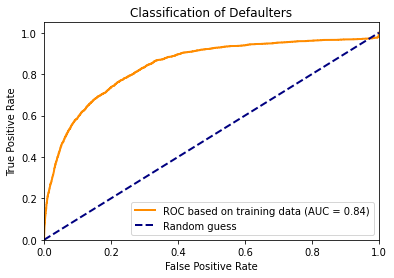

In [64]:
roc_curve_plot(y, model_svm_bl_sig_proba[:,1])

This kernel shows a very low value of AUC. For the first time in all of the SVM model I have a value of AUC different that 0.96. Lets go directly to run a grid search in order to get a better model and see how the AUC metric behaves for different values of C.

In [70]:
svm_params_3 = {'C': [0.001, 0.01, 0.1, 1, 3, 5, 10],
                 'gamma' : ['scale', 'auto']}

svm_gs3 = GridSearchCV(SVC(kernel='sigmoid', class_weight = 'balanced'),
                       param_grid = svm_params_3,
                       scoring = 'roc_auc',
                       n_jobs = -1,
                       cv=5,
                       refit = False,
                       verbose = 2)

In [71]:
svm_gs3.fit(X_train, y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='sigmoid'),
             n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 3, 5, 10],
                         'gamma': ['scale', 'auto']},
             refit=False, scoring='roc_auc', verbose=2)

In [72]:
svm_gs3.best_params_

{'C': 0.01, 'gamma': 'scale'}

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

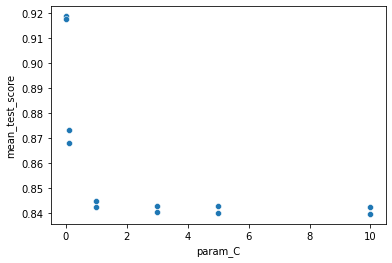

In [75]:
df_results_svm_gs3 = pd.DataFrame(svm_gs3.cv_results_)
#df_results_svm_gs3.sort_values(by = 'mean_test_score', ascending=False).head()
sns.scatterplot(x = 'param_C', y = 'mean_test_score', data = df_results_svm_gs3)

<AxesSubplot:ylabel='Density'>

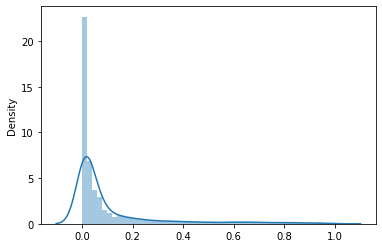

In [77]:
model_svm_m6_sig = SVC(kernel='sigmoid', probability=True, class_weight='balanced', C =  0.01, gamma = 'scale')

model_svm_m6_sig.fit(X_train, y)
y_test_hat_svm_m6_sig = model_svm_m6_sig.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m6_sig[:,1])

In [79]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m6_sig[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m6_sig.csv", index = False)

There is more room for grid search, lets do a bit more to see if we can improve the AUC

In [80]:
svm_params_4 = {'C': [0.007, 0.008, 0.009, 0.010, 0.011, 0.012, 0.013, 0.014, 0.015]}

svm_gs4 = GridSearchCV(SVC(kernel='sigmoid', class_weight = 'balanced', gamma = 'scale'),
                       param_grid = svm_params_4,
                       scoring = 'roc_auc',
                       n_jobs = -1,
                       cv=5,
                       refit = False,
                       verbose = 2)

In [81]:
svm_gs4.fit(X_train, y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=SVC(class_weight='balanced', kernel='sigmoid'),
             n_jobs=-1,
             param_grid={'C': [0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013,
                               0.014, 0.015]},
             refit=False, scoring='roc_auc', verbose=2)

In [86]:
svm_gs4.best_params_

{'C': 0.015}

<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

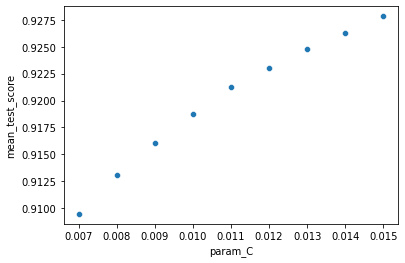

In [85]:
df_results_svm_gs4 = pd.DataFrame(svm_gs4.cv_results_)
sns.scatterplot(x = 'param_C', y = 'mean_test_score', data = df_results_svm_gs4)

In [89]:
svm_params_5 = {'C': [0.015, 0.018, 0.021, 0.024, 0.027, 0.030, 0.033, 0.036, 0.040]}

svm_gs5 = GridSearchCV(SVC(kernel='sigmoid', class_weight = 'balanced', gamma = 'scale'),
                       param_grid = svm_params_5,
                       scoring = 'roc_auc',
                       n_jobs = -1,
                       cv=5,
                       refit = False,
                       verbose = 2)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'C': 0.024}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

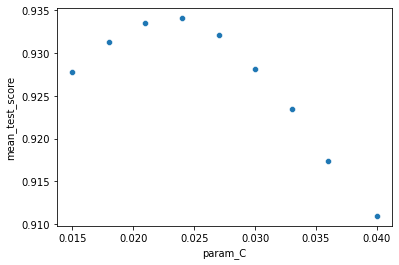

In [90]:
svm_gs5.fit(X_train, y)
print(svm_gs5.best_params_)

df_results_svm_gs5 = pd.DataFrame(svm_gs5.cv_results_)
sns.scatterplot(x = 'param_C', y = 'mean_test_score', data = df_results_svm_gs5)

After the grid search the best C is 0.024 wich shows a AUC over 0.93. This is a good improvemnt from the 0.83 in the basic sigmoid SVM. Lets compute probabilities over the test dataset and upload them to kaggle.

<AxesSubplot:ylabel='Density'>

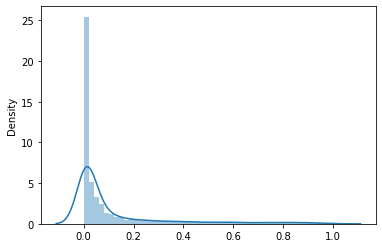

In [92]:
model_svm_m7_sig = SVC(kernel='sigmoid', probability=True, class_weight='balanced', C =  0.024, gamma = 'scale')

model_svm_m7_sig.fit(X_train, y)
y_test_hat_svm_m7_sig = model_svm_m7_sig.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m7_sig[:,1])

In [93]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m7_sig[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m7_sig.csv", index = False)

Over this model, lets see what happend when I recalibrate probabilities.

In [94]:
calibrated = CalibratedClassifierCV(model_svm_m7_sig, method='isotonic', cv=3) 
model_svm_m6_sig_proba_cal = cross_val_predict(calibrated,
                          X_train, 
                          y,
                          cv = 5,
                          n_jobs=-1,
                          method='predict_proba') 

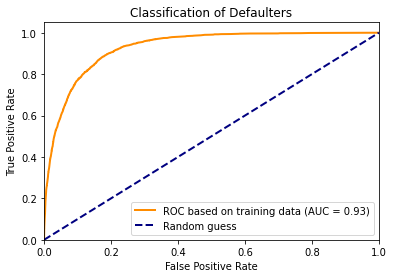

In [95]:
roc_curve_plot(y, model_svm_m6_sig_proba_cal[:,1])

In [96]:
roc_auc_score(y, model_svm_m6_sig_proba_cal[:,1])

0.9282367059754394

The calibrated probabilities does not improve the observed AUC. However, I want to upload predicted probabilities from this model.

In [103]:
# Delete
model_svm_m7_sig = SVC(kernel='sigmoid', probability=True, class_weight='balanced', C =  0.024, gamma = 'scale')
calibrated = CalibratedClassifierCV(model_svm_m7_sig, method='isotonic', cv=3) 

<AxesSubplot:ylabel='Density'>

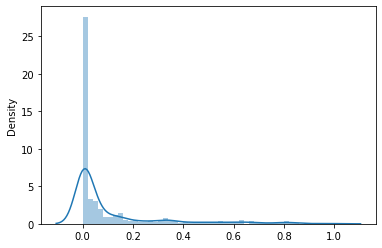

In [104]:
calibrated.fit(X_train, y)
y_test_hat_svm_m7_sig_cal = calibrated.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m7_sig_cal[:,1])

In [105]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m7_sig_cal[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m7_sig_cal.csv", index = False)

### Trying the poly kernel

Here I will follow the same process that I did for Sigmoid and Radial kernels. 

In [100]:
# Baseline model with rbf kernel

model_svm_bl_poly = SVC(kernel='poly', probability=True, class_weight='balanced')

# Get the predicted proba by cross validation to measure the expeted AUC
model_svm_bl_poly_proba = cross_val_predict(model_svm_bl_poly, 
                                           X_train, 
                                           y, 
                                           cv = 5, 
                                           n_jobs = -1, 
                                           method='predict_proba',
                                           verbose = 3)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed: 21.0min remaining: 31.5min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed: 24.0min finished


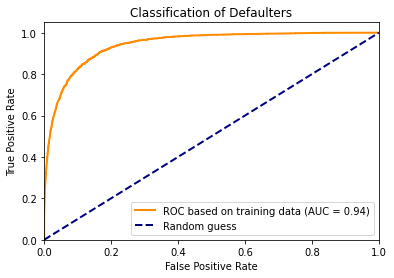

In [101]:
roc_curve_plot(y, model_svm_bl_poly_proba[:,1])

In [107]:
svm_params_6 = {'C': [0.001, 0.01, 0.1, 1, 3, 5, 10],
                 'gamma' : ['scale', 'auto'],
             }

svm_gs6 = GridSearchCV(SVC(kernel='poly', class_weight = 'balanced'),
                       param_grid = svm_params_6,
                       scoring = 'roc_auc',
                       n_jobs = -1,
                       cv=5,
                       refit = False,
                       verbose = 2)

In [108]:
start_time = datetime.now()
svm_gs6.fit(X_train, y)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

Fitting 5 folds for each of 14 candidates, totalling 70 fits
Duration: 1:08:41.021030


In [109]:
print(svm_gs6.best_params_)

{'C': 1, 'gamma': 'scale'}


<AxesSubplot:xlabel='param_C', ylabel='mean_test_score'>

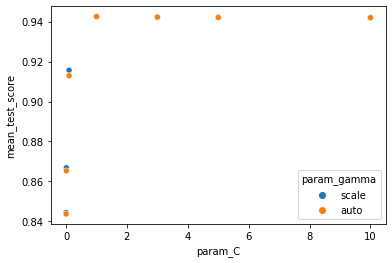

In [112]:
df_results_svm_gs6 = pd.DataFrame(svm_gs6.cv_results_)
sns.scatterplot(x = 'param_C', y = 'mean_test_score', hue='param_gamma', data = df_results_svm_gs6)

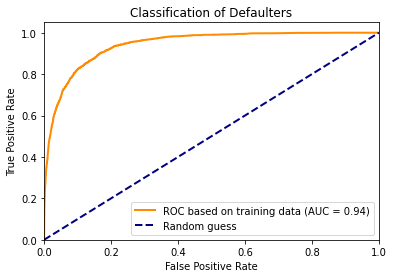

In [113]:
calibrated = CalibratedClassifierCV(model_svm_bl_poly, method='isotonic', cv=5) 
model_svm_bl_poly_proba_cal = cross_val_predict(calibrated,
                          X_train, 
                          y,
                          cv = 5,
                          n_jobs=-1,
                          method='predict_proba') 

roc_curve_plot(y, model_svm_bl_poly_proba_cal[:,1])

<AxesSubplot:ylabel='Density'>

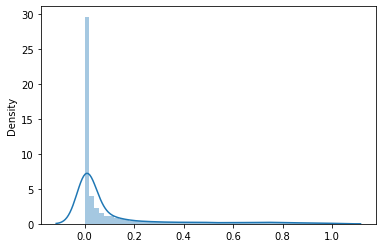

In [116]:
calibrated.fit(X_train, y)
y_test_hat_svm_m8_poly_cal = calibrated.predict_proba(X_test)
sns.distplot(y_test_hat_svm_m8_poly_cal[:,1])

In [117]:
# Export the probabilities
test_predictions_submit = pd.DataFrame({"icustay_id": X_test.index, "HOSPITAL_EXPIRE_FLAG": y_test_hat_svm_m8_poly_cal[:,1]})
test_predictions_submit.to_csv("data/outputs/svm_m8_poly_cal.csv", index = False)

## Final remarks

In this notebook I have run multiple KNN and SVM models for predicting the probability of death of patients entered into the ICU with data from the MIMIC project (https://mimic.physionet.org/). I started with basic models and I tried to improve the first fitting for each algorith (KNN and SVM)

The main strategies followed to improve the predictions were to manage the class imbalance and the hyperparamenter tunning of each algorithm. To manage the class imbalance problem I tried the resampling approaches as well as the calibration of probabilties.

The undersampling methods showed a good improvement in the KNN models, However when I tried to do the same in the linear SVM I couldn't find any improvement. Similarly, the calibration methods used shown a better improvement in the KNN algorith than in the SVM.

The best KNN algorithm found according with the cross-validated AUC is based in a undersampled training data set by the Neighborhood Cleaning Rule with parameters K = 10 and selection = 'all'. Over this training data set the best KNN model have 30 neighboors and it uses weighted euclidean distances.

On the other hand, since the first and most basic SVM, all of the SVM kernels used to make predictions with the exception of the 'sigmoid' kernel showed good values of AUC. However I could not improve the initial AUC using resampling, hyperparamenter tunning or calibration of probabilities. For this reason, the most trusted SVM model uses the sigmoid kernel, the option for balancing classes and a value for reguralization C of 0.024. Under theses parameters the AUC increased from 0.84 to 0.93.